In [2]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


/home/sergey/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Визуализация

Посмотрим на данные

In [11]:
salary = pd.read_csv('WAG_C_M.csv',';',index_col=['month'], parse_dates=['month'], dayfirst=True)
salary.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


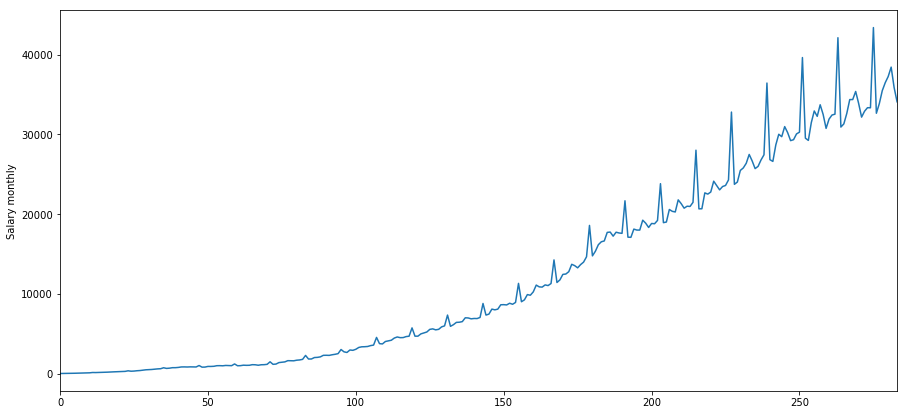

In [10]:
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
plt.ylabel('Salary monthly')
pylab.show()

# Стабилизация дисперсии

Наблюдаем тренд и сезонность. Также наблюдается нестационарность ряда, требуется стабилизация дисперсии. Для этого используем преобразование Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


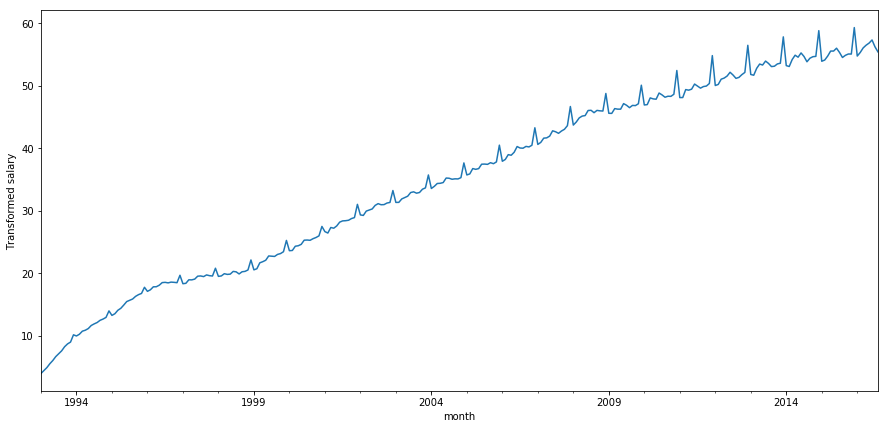

In [12]:
salary['wag_box'], lmbda = stats.boxcox(salary.WAG_C_M)
plt.figure(figsize(15,7))
salary.wag_box.plot()
plt.ylabel(u'Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.wag_box)[1])

# Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


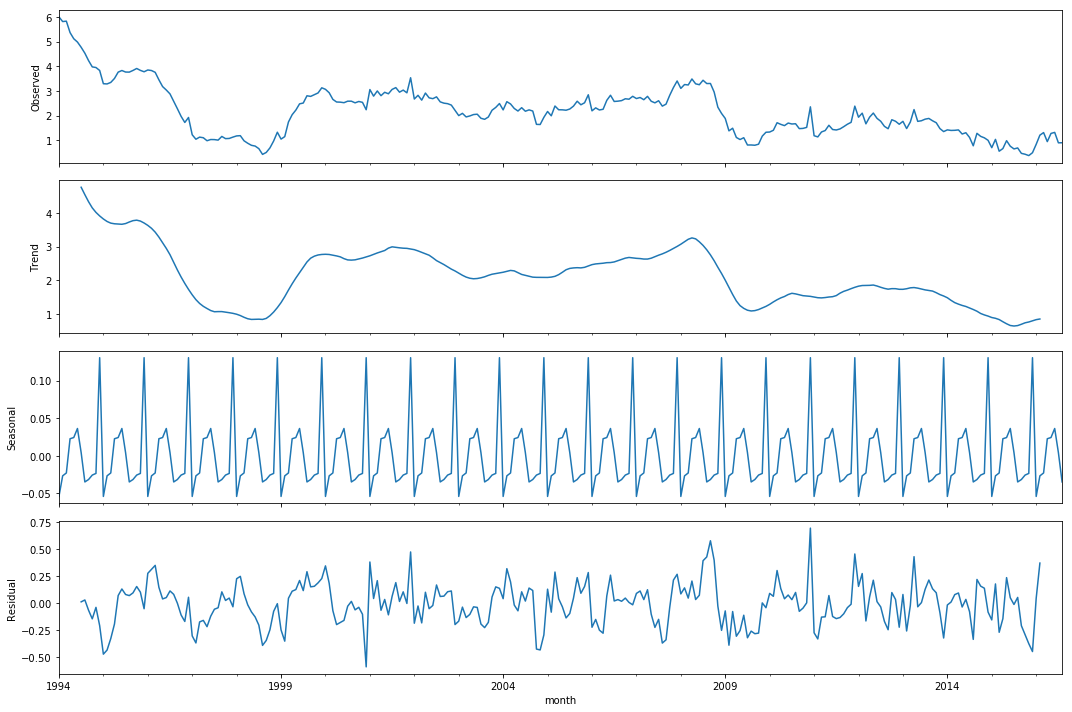

In [14]:
salary['wag_box_diff'] = salary.wag_box - salary.wag_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.wag_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.wag_box_diff[12:])[1])

На уровне значимости 0.05 критерий Дики-Фуллера отвергает гипотезу нестационарности, полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:


Критерий Дики-Фуллера: p=0.000000


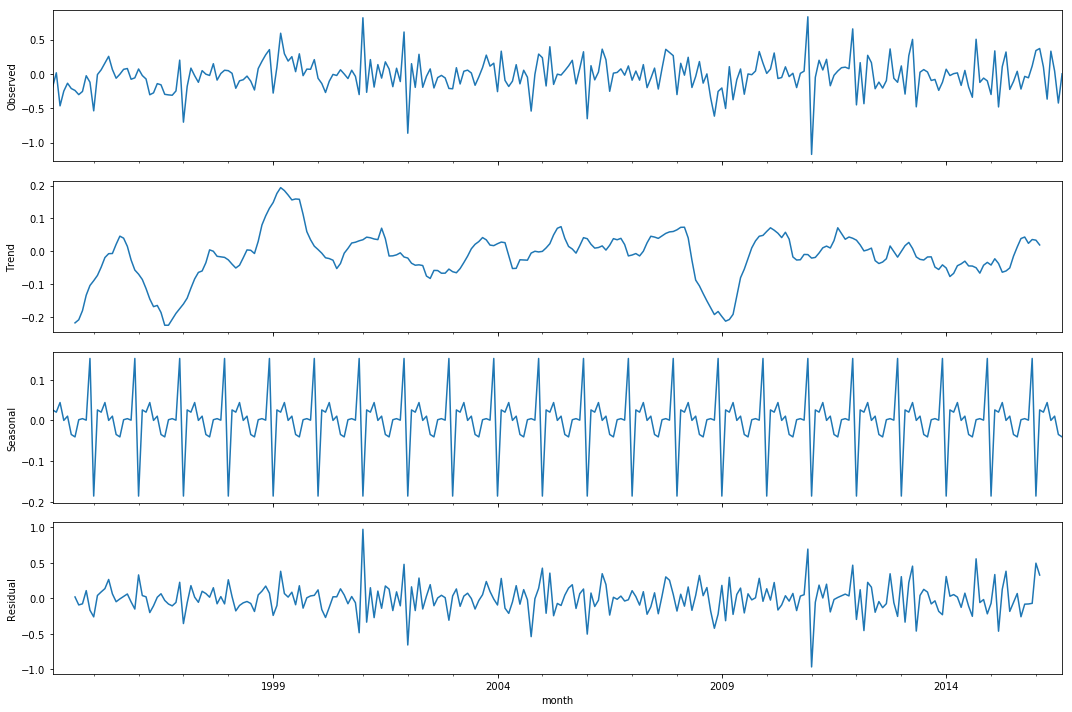

In [15]:
salary['wag_box_diff2'] = salary.wag_box_diff - salary.wag_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.wag_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.wag_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

# Подбор модели

Посмотрим на ACF и PACF полученного ряда:

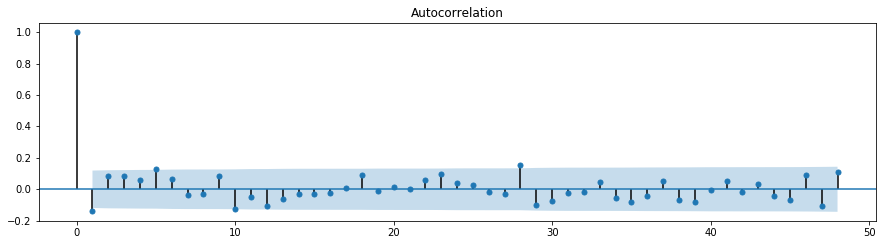

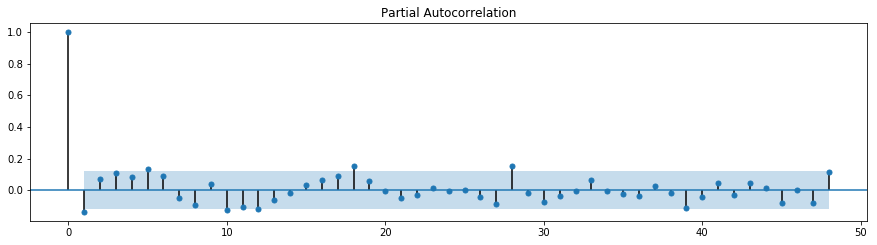

In [16]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.wag_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.wag_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения я бы взял следующие: Q=0,q=1, P=0,p=1

In [17]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 1)
D=1
Qs = range(0, 1)

In [18]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

4

In [19]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.wag_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
CPU times: user 1.16 s, sys: 28 ms, total: 1.19 s
Wall time: 1.02 s


In [20]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters       aic
1  (1, 0, 0, 0)  2.625709
0  (0, 1, 0, 0)  3.369832
2  (1, 1, 0, 0)  4.003439


Лучшая модель:

In [21]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            wag_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                   0.687
Date:                            Tue, 16 May 2017   AIC                              2.626
Time:                                    18:52:27   BIC                              9.924
Sample:                                01-01-1993   HQIC                             5.552
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1300      0.048     -2.733      0.006      -0.223      -0.037
sigma2         0.0582      0.004   

Её остатки:

Критерий Стьюдента: p=0.146496
Критерий Дики-Фуллера: p=0.000000


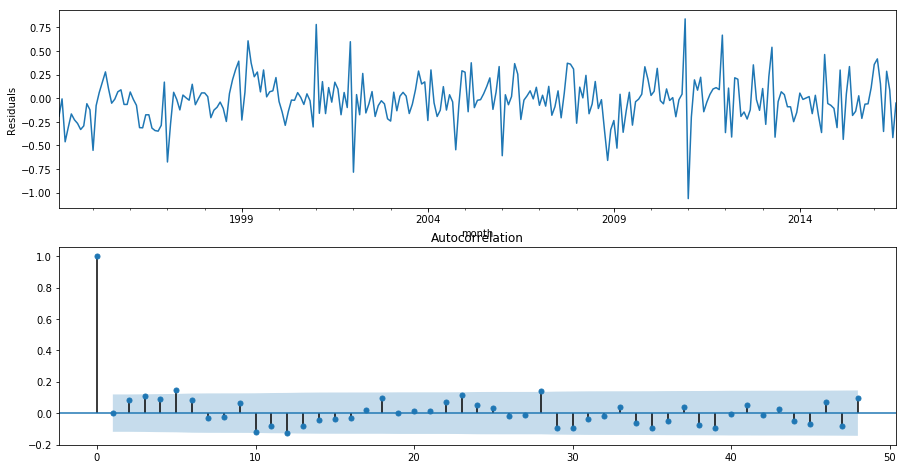

In [22]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

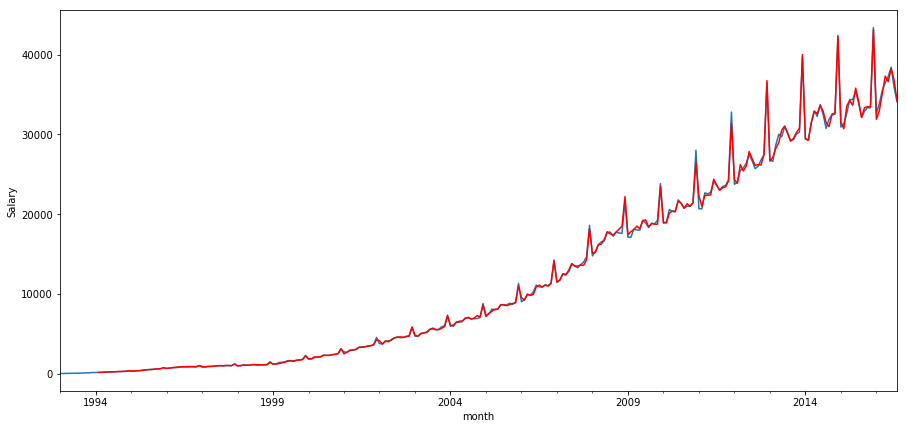

In [24]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Salary')
pylab.show()

# Прогноз

Делаем на два года вперед согласно заданию.

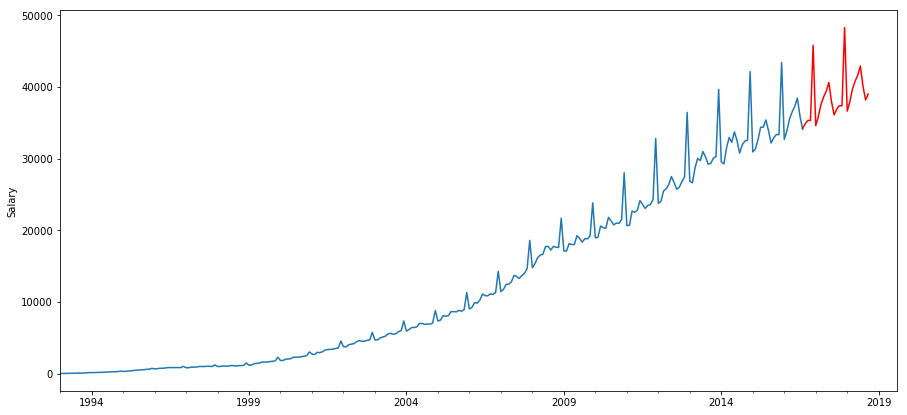

In [27]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start="2016-08-01", end="2018-09-01"), lmbda)

plt.figure(figsize(15,7))
salary2.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()

Отмечу, что в файле содержатся данные по август 2016 года, хотя сегодня уже май 2017, т.е. прошло уже полгода. Интересно было бы посмотреть насколько совпадет прогноз с реальными данными. Добавив свежие данные по март 2017 года, я построил два графика с частичным наложением.

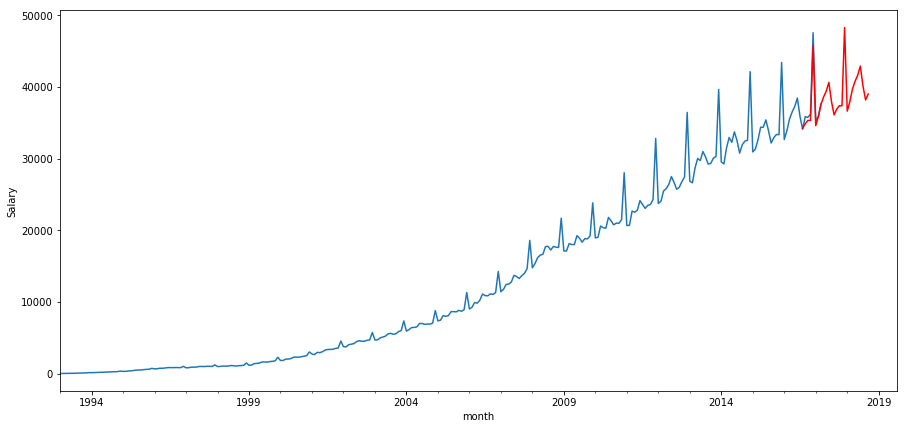

In [33]:
salary_new = pd.read_csv('WAG_C_M_2.csv',';',index_col=['month'], parse_dates=['month'], dayfirst=True)

plt.figure(figsize(15,7))
salary_new.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Salary')

pylab.show()